# mini test

In [1]:
# 1.세팅
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import json

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
torch_dtype = torch.float32
print("------------------ Setup Check ------------------")
print("Using device:", device)
print("Using torch_dtype:", torch_dtype)

# 2.모델 로드
model_id = "microsoft/Florence-2-large"

# print("Loading Florence-2 Large model...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)

# 3.테스트 데이터 로드
image_path = "./data/test01_re.JPG"
image = Image.open(image_path).convert("RGB")

def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    print(parsed_answer)
    return parsed_answer
    
prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
vlm_result = run_example(prompt, text_input="Extract blocks and lines from the schematic.")
shapes = vlm_result['<CAPTION_TO_PHRASE_GROUNDING>']
blocks = shapes['bboxes']
labels = shapes['labels']

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


------------------ Setup Check ------------------
Using device: cuda:0
Using torch_dtype: torch.float32
{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[0.12999999523162842, 0.210999995470047, 259.8699951171875, 421.78900146484375], [104.64999389648438, 50.85099792480469, 221.12998962402344, 409.9729919433594], [104.90999603271484, 51.27299880981445, 220.8699951171875, 409.9729919433594]], 'labels': ['Extract blocks', 'Extract blocks', 'lines']}}


In [2]:
vlm_result

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[0.12999999523162842,
    0.210999995470047,
    259.8699951171875,
    421.78900146484375],
   [104.64999389648438,
    50.85099792480469,
    221.12998962402344,
    409.9729919433594],
   [104.90999603271484,
    51.27299880981445,
    220.8699951171875,
    409.9729919433594]],
  'labels': ['Extract blocks', 'Extract blocks', 'lines']}}

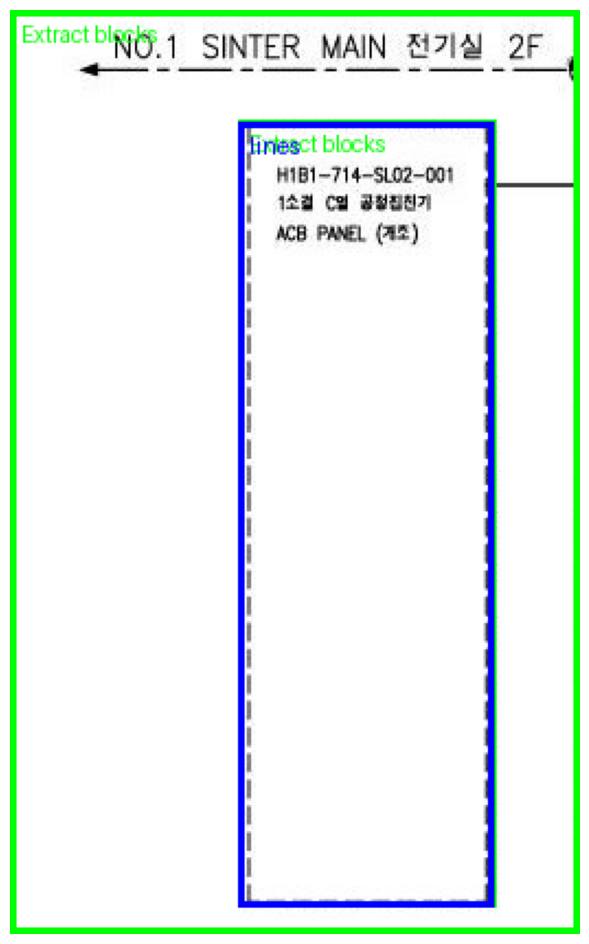

: 

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)

bboxes = vlm_result['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']
labels = vlm_result['<CAPTION_TO_PHRASE_GROUNDING>']['labels']

# 3️⃣ 색상 매핑 (블록 → 초록, 선 → 파랑)
color_map = {
    "Extract blocks": (0, 255, 0),
    "lines": (0, 0, 255)
}

# 4️⃣ 시각화
for bbox, label in zip(bboxes, labels):
    x0, y0, x1, y1 = map(int, bbox)
    draw.rectangle([x0, y0, x1, y1], outline=color_map.get(label, (255,0,0)), width=3)
    draw.text((x0+5, y0+5), label, fill=color_map.get(label, (255,0,0)))

# 5️⃣ 출력
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.show()
